In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

!git clone https://github.com/spMohanty/PlantVillage-Dataset.git

fatal: destination path 'PlantVillage-Dataset' already exists and is not an empty directory.


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
from pathlib import Path

source_path = Path("PlantVillage-Dataset/raw/color")
source_dir = source_path
dest_dir = "/content/plantvillage"
train_dir = os.path.join(dest_dir, "train")
test_dir = os.path.join(dest_dir, "test")

# Create train/test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Loop through each class folder
for class_name in os.listdir(source_dir):
  class_path = os.path.join(source_dir, class_name)
  if not os.path.isdir(class_path):
      continue  # skip files if any

  # Get all images in the class folder
  images = [f for f in os.listdir(class_path) if f.endswith(('.JPG', '.JPEG', '.PNG'))]

  # Full paths to images

  images_full_path = [os.path.join(class_path, f) for f in images]
  # Train-test split
  train_imgs, test_imgs = train_test_split(images_full_path, test_size=0.2, random_state=42)

  # Create class subfolders in train/test directories
  os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
  os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

  # Move train images
  for img_path in train_imgs:
      shutil.copy(img_path, os.path.join(train_dir, class_name, os.path.basename(img_path)))

  # Move test images
  for img_path in test_imgs:
      shutil.copy(img_path, os.path.join(test_dir, class_name, os.path.basename(img_path)))

print("✅ Done! Your dataset is now split and organized.")

✅ Done! Your dataset is now split and organized.


In [ ]:
!pip install timm

In [ ]:
from timm.data.mixup import Mixup
mixup_fn = Mixup(cutmix_alpha=0.8, # it cuts a patch from one image and pastes it onto another.
                 mixup_alpha=0.4, # controls how much blending happens in MixUp.
                 prob=1.0, # probability of applying either MixUp or CutMix (1.0 = always apply)
                 switch_prob = 0.5, # 50% chance = MixUp # 50% chance = CutMix
                 mode="batch",  # apply the same mixing to the whole batch
                 num_classes = 38) # otherwise defaults to 1000 (assume ImageNet)
                 # 'pair' (mix samples in pairs individually) or 'elem' (per element).

mixup_fn # apply during training before feeding in a batch from DataLoader

In [ ]:
data_path = Path("plantvillage")
train_dir = data_path / "train"
test_dir = data_path / "test"

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


train_data_transform = transforms.Compose([transforms.Resize(size=(128,128)),
                                           transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.2),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
                                     transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                    transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)])

test_data_transform= transforms.Compose([transforms.Resize(size=(128,128)),
                                    transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)])

train_data = datasets.ImageFolder(root=train_dir,
                                  transform = train_data_transform)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform = test_data_transform)

len(test_data), len(train_data)

(10577, 42226)

In [ ]:
from torch.utils.data import DataLoader
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset = train_data,
                             shuffle=True,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS)
test_dataloader = DataLoader(dataset=test_data,
                              shuffle=False,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS)

image, label = next(iter(test_dataloader))
print(f"Shape: {image.shape}")
print(f"Label: {label}")

train_data

Shape: torch.Size([32, 3, 128, 128])
Label: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


Dataset ImageFolder
    Number of datapoints: 42226
    Root location: plantvillage/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-25.0, 25.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=(0.7, 1.3), hue=(-0.2, 0.2))
               RandomPerspective(p=0.5)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [ ]:
class_names = train_data.classes
class_dict = train_data.class_to_idx

class_names, class_dict

(['Apple___Apple_scab',
  'Apple___Black_rot',
  'Apple___Cedar_apple_rust',
  'Apple___healthy',
  'Blueberry___healthy',
  'Cherry_(including_sour)___Powdery_mildew',
  'Cherry_(including_sour)___healthy',
  'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
  'Corn_(maize)___Common_rust_',
  'Corn_(maize)___Northern_Leaf_Blight',
  'Corn_(maize)___healthy',
  'Grape___Black_rot',
  'Grape___Esca_(Black_Measles)',
  'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
  'Grape___healthy',
  'Orange___Haunglongbing_(Citrus_greening)',
  'Peach___Bacterial_spot',
  'Peach___healthy',
  'Pepper,_bell___Bacterial_spot',
  'Pepper,_bell___healthy',
  'Potato___Early_blight',
  'Potato___Late_blight',
  'Potato___healthy',
  'Raspberry___healthy',
  'Soybean___healthy',
  'Squash___Powdery_mildew',
  'Strawberry___Leaf_scorch',
  'Strawberry___healthy',
  'Tomato___Bacterial_spot',
  'Tomato___Early_blight',
  'Tomato___Late_blight',
  'Tomato___Leaf_Mold',
  'Tomato___Septoria_leaf_spot',
  '

In [ ]:
import torch
from torchvision.models import resnet18
device = "cuda" if torch.cuda.is_available() else "cpu"

model_loaded = resnet18(weights=None)
model_loaded.fc = torch.nn.Linear(in_features=512, out_features=38)

model_loaded.load_state_dict(torch.load("fc+layer3+layer4+RealWorld+PlantVillageModelV6.pth"))

model_loaded.eval()
model_loaded.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch
from torch import nn

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(lr=1e-3, params=model_loaded.parameters(),weight_decay=1e-4)

scheduler_1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                              mode="min", # because we're monitoring validation loss
                              patience=3, # wait 3 epochs before reducing
                              factor=0.5, # halve the LR
                              verbose=True)  # print update

from tqdm.auto import tqdm

# Measure time
from timeit import default_timer as timer
start_time = timer()

torch.manual_seed(42)

epochs = 5

model_loaded.train()

results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

for epoch in tqdm(range(epochs)):
  y_preds= []
  train_loss, train_acc = 0, 0
  test_loss, test_acc = 0,0
  print(f"Epoch: {epoch}\n---------")
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = mixup_fn(X, y)  # y is already in soft labels



    #print(y.shape) # output: 32, 1000
    # y = torch.nn.functional.one_hot(y.long(), num_classes=38).float()
    #print(y.shape) # output: 32, 1000, 38
    # y = F.one_hot(y, num_classes=38).float()
    X, y = X.to(device), y.to(device)
    y_logits = model_loaded(X)
    loss = loss_fn(y_logits, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_labels = y_logits.argmax(dim=1)
    y_true_labels = y.argmax(dim=1)
    train_acc += (y_labels==y_true_labels).sum().item()/len(y_logits)

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  scheduler_1.step(train_loss)

  model_loaded.eval()

  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(test_dataloader):
      X_test, y_test = X_test.to(device), y_test.to(device)
      y_test_oh = torch.nn.functional.one_hot(y_test, num_classes=38).float()
      test_y_logits = model_loaded(X_test)
      loss = loss_fn(test_y_logits, y_test_oh)
      test_loss += loss.item()

      test_y_labels = test_y_logits.argmax(dim=1)
      y_true_labels = y_test_oh.argmax(dim=1)
      y_preds.append(test_y_labels.cpu())
      test_acc += (test_y_labels == y_true_labels).sum().item()/len(test_y_logits)

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)



    print(f"Train Loss: {train_loss} | Train Acc: {train_acc}")
    print(f"Test Loss: {test_loss} | Test Acc: {test_acc}")

  y_pred_tensor = (torch.cat(y_preds))
  results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
  results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
  results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
  results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train Loss: 0.09972604543647982 | Train Acc: 0.4052951388888889
Test Loss: 0.04889044938524594 | Test Acc: 0.6682401812688822
Epoch: 1
---------
Train Loss: 0.08855097257447514 | Train Acc: 0.4650410353535353
Test Loss: 0.03918344772834432 | Test Acc: 0.7483950151057401
Epoch: 2
---------
Train Loss: 0.0856163943271068 | Train Acc: 0.5009075126262627
Test Loss: 0.038410305446492134 | Test Acc: 0.7548260618446775
Epoch: 3
---------
Train Loss: 0.08530174988237295 | Train Acc: 0.5091172138047138
Test Loss: 0.03556093150958014 | Test Acc: 0.7857817220543807
Epoch: 4
---------
Train Loss: 0.08465340479531071 | Train Acc: 0.511908143939394
Test Loss: 0.035548753265482784 | Test Acc: 0.7780622445352763
Total training time: 246.266 seconds


In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "fc+3+4_RealWorld+PlantVillageModelV7.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_loaded.state_dict(), f = MODEL_SAVE_PATH)

Saving model to: models/fc+3+4_RealWorld+PlantVillageModelV7.pth


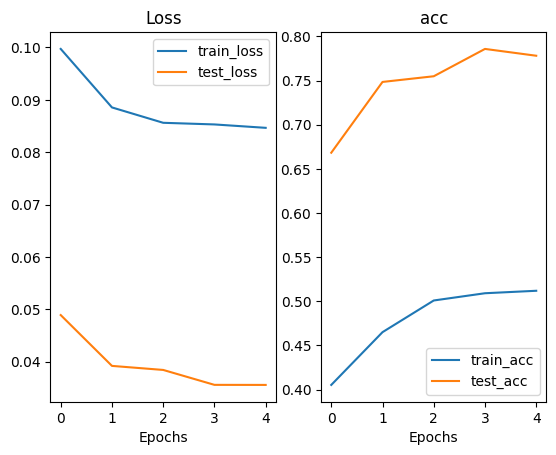

In [ ]:
import matplotlib.pyplot as plt
train_acc = results["train_acc"]
test_acc = results["test_acc"]
train_loss = results["train_loss"]
test_loss = results["test_loss"]
epochs = range(len(results["train_loss"]))


plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label="train_loss")
plt.plot(epochs, test_loss, label = "test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend();

plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label="train_acc")
plt.plot(epochs, test_acc, label = "test_acc")
plt.title("acc")
plt.xlabel("Epochs")
plt.legend();